In [15]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

import math
from math import pi
from qiskit.circuit.library import MCMT

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    
    #####################
    # added code - Ashwin
    counts = result.get_counts(circuit)
    return counts
    #####################
    
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    #for i in range(2,20):
    #    assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [16]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

0.0035832372164552096
0.0035832372164552096


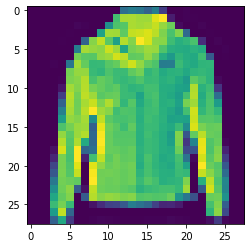

In [17]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1946])
labels[1946]
print(max(images[1946][2]))
print(images[1946][2][16])

In [50]:
#submission to part 1, you should make this into a .py file

n=len(dataset)
mse=0
gatecount=0

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    num_qubits = int(math.log(len(image) * len(image), 2) + 1)
    #print(num_qubits)
    
    q = qiskit.QuantumRegister(num_qubits)
    a = qiskit.QuantumRegister(1)
    circuit = qiskit.QuantumCircuit(q, a)
    
    index_qubits = []
    # initializes circuit with Hadamard gates other than last qubit
    for i in range(num_qubits):
        circuit.h(i)
        index_qubits.append(i)
    count = 0
    theta_list = []
    
    # implements rest of FRQI
    for index in range(pow(2, num_qubits)):
        if index < len(image) * len(image):
            theta = image[int(index / len(image))][index % len(image)]
            theta_list.append(theta)
        else:
            theta_list.append(0)         
    
    #print(len(theta_list))
    circuit.ucry(angle_list = theta_list, q_controls = index_qubits, q_target = num_qubits)
            
    return circuit

def decode(histogram):
    num_qubits = len(list(histogram.keys())[0]) - 1
    #print(histogram)
    
    image = [ [0] * 28 for i in range(28)]
    
    for key in histogram.keys():
        
        color = int(key[:1])
        index = int('0b' + key[1:], 2)
            
        if index < 784 and color == 1:
            if ('0' + key[1:]) in histogram:
                key0 = '0' + key[1:]
                image[int(index / 28)][index % 28] = (histogram[key]) / (histogram[key0] + histogram[key])
            else:
                image[int(index / 28)][index % 28] = 1
        
            
    return image

def run_part1(image):    
    #plt.imshow(image)
    #print('done')
    
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    plt.imshow(image_re)
    
    return circuit,image_re

0.9999951753431863


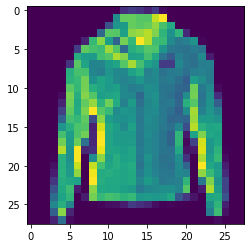

In [51]:
#how we grade your submission

n= 1 #len(dataset)
mse=0
gatecount=0

images=np.load('data/images.npy')

count = 0 

for data in dataset:
    print(count)
    count += 1 # really bad progress bar
    
    #print(data)
    #encode image into circuit
    circuit,image_re=run_part1(data)
   
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data,image_re)

#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))